In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import creme
import shuffle
import utils
import shutil
import pickle
import custom_model
import glob
import pandas as pd
import numpy as np
import itertools, os
from tqdm import tqdm
from scipy.stats import pearsonr

2023-12-19 07:01:16.136885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cell_lines = [4824, 5110, 5111]
cell_line_names = ['PC-3', 'GM12878', 'K562']
bin_index = [447, 448]
model_name = 'enformer'
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/context/')

In [36]:
summary_combined = pd.read_csv('../results/summary_csvs/enformer/context_dependence_test.csv')

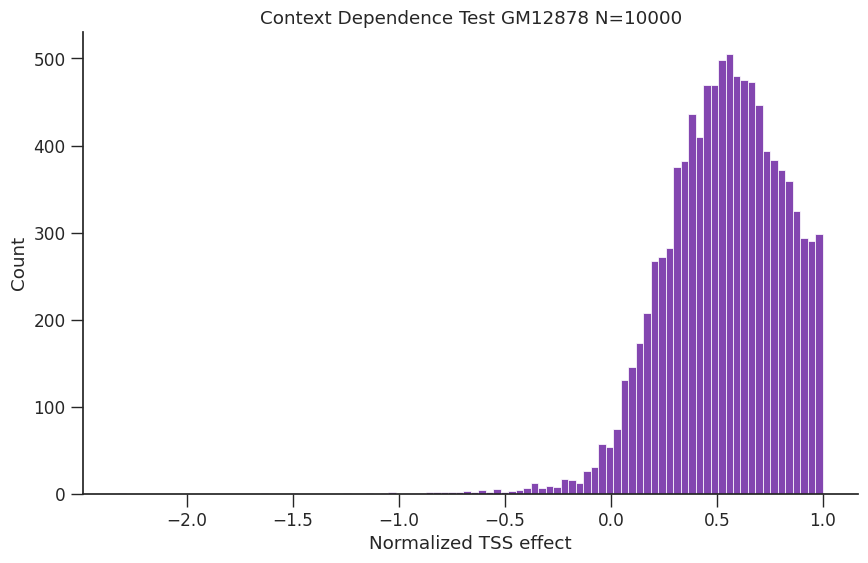

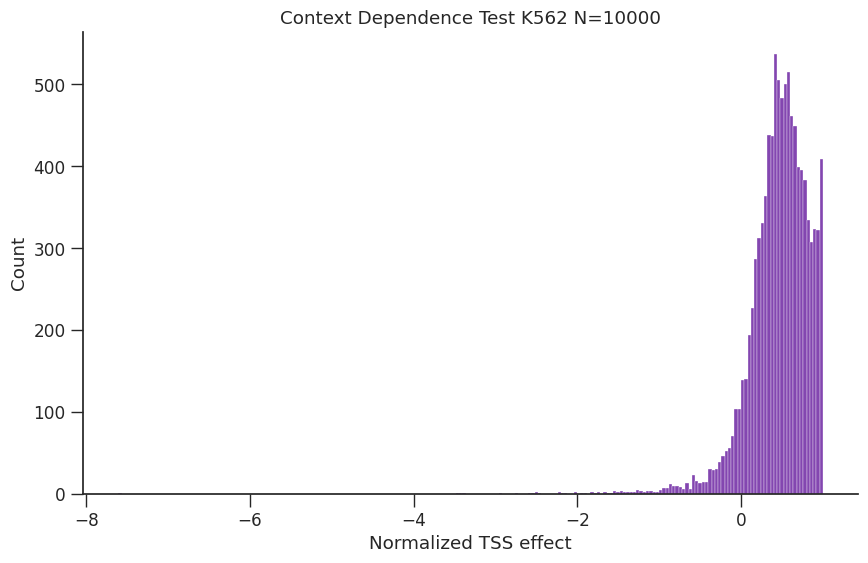

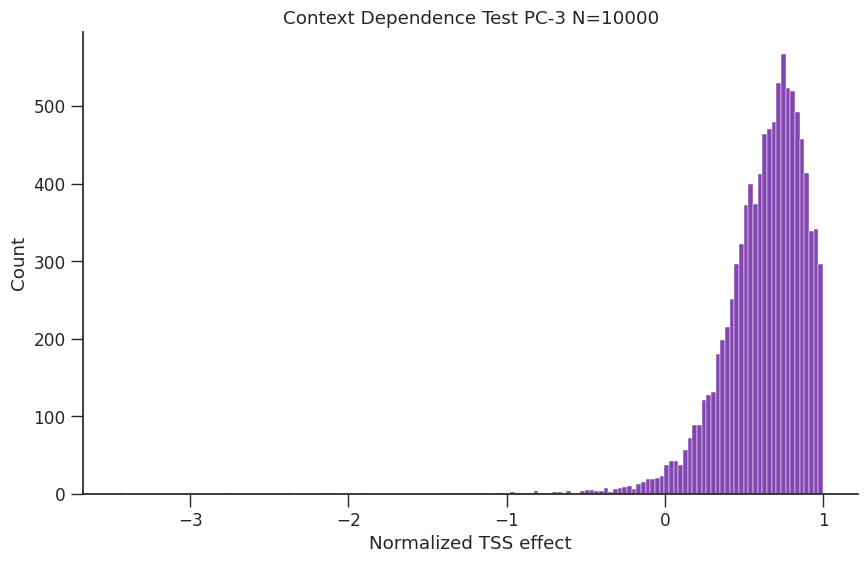

In [8]:
sns.set(font_scale = 1.1)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
for k, df in summary_combined.groupby('cell_line'):
    
    fig = plt.figure(figsize=[10, 6])
    ax = sns.histplot(x=df['delta_mean'], color='#5A0896')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Normalized TSS effect') # (WT - M) / WT
    plt.title(f'Context Dependence Test {k} N={df.shape[0]}')
    fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_hist.pdf', format='pdf', dpi=300, bbox_inches='tight')


['enhancing (N=200)', 'neutral (N=110)', 'silencing (N=90)']
['enhancing (N=200)', 'neutral (N=183)', 'silencing (N=78)']
['enhancing (N=200)', 'neutral (N=200)', 'silencing (N=200)']


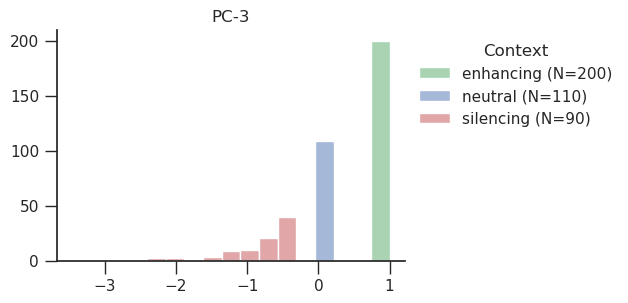

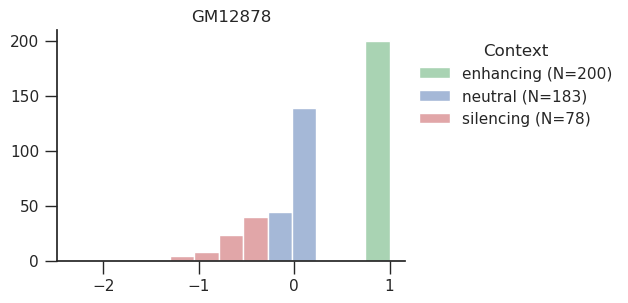

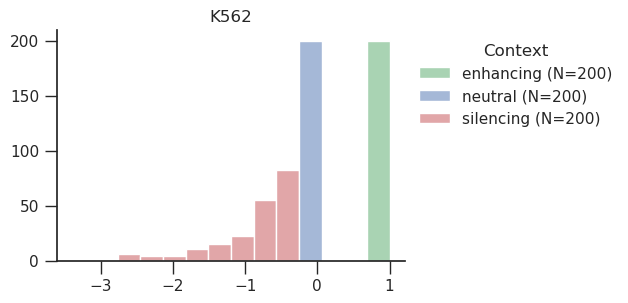

In [27]:
for k in cell_line_names:
    
    fig = plt.figure(figsize=[4.5, 3])
    sns.set(font_scale = 1.)
    sns.set_style(style='white')
    plt.rcParams['xtick.major.size'] = 9
    plt.rcParams['xtick.major.width'] = 1
    
    plt.rcParams['ytick.major.size'] = 9
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
  
    for context_type, one_context_df in context_df.groupby('context'):
        # print(one_context_df.shape)
        if one_context_df.shape[0] > max_sample_size:
            
            context_df_subsample.append(one_context_df.sample(max_sample_size, random_state=42))
        else:
            context_df_subsample.append(one_context_df)
    context_df = pd.read_csv(f'../results/summary_csvs/enformer/{k}_selected_contexts.csv').sort_values('context')

    ax = sns.histplot(data=context_df, 
                      x='delta_mean', hue='context', 
                      hue_order=['enhancing', 'neutral', 'silencing'],
                      palette=['g', 'b', 'r'])
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.legend(frameon=False);
    legend = ax.get_legend()
    handles = legend.legend_handles
    legend.remove()
    labels = [f"{c} (N={s})" for _, (c, s) in context_df.groupby('context').count().reset_index().iloc[:,:2].iterrows() 
              if 'other' not in c]
    print(labels)
    ax.legend(handles, labels,
              title='Context', frameon=False, bbox_to_anchor=[1,1])
    
    plt.ylabel('')
    plt.xlabel('')
    
    plt.title(k)

    fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_inset.pdf', format='pdf', dpi=300, bbox_inches='tight')


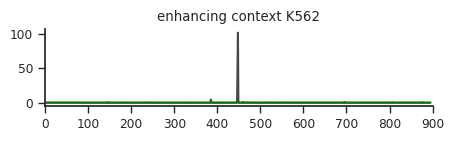

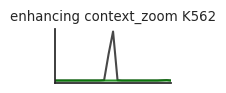

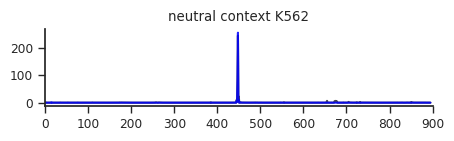

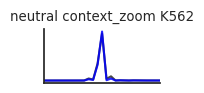

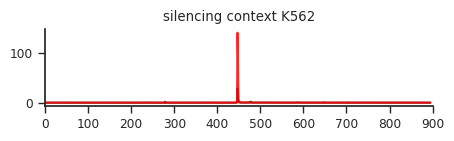

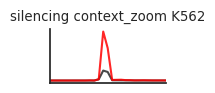

In [30]:
k = 'K562'
df = pd.read_csv(f'../results/summary_csvs/enformer/{k}_selected_contexts.csv').sort_values('context')
cell_pred_index = cell_line_names.index(k)

# select most illustrative cases

for name, color, selected_point in zip(['enhancing context', 'neutral context', 'silencing context'],
                                ['green', 'blue', 'red'],
                                [df[df['context']=='enhancing'].sort_values('delta_mean')['path'].values[-1],
                                 df[df['context']=='neutral']['path'].values[0],
                                 df[df['context']=='silencing'].sort_values('delta_mean')['path'].values[0]
                                 ]):
    with open(selected_point, 'rb') as handle:
        context_res = pickle.load(handle)
    wt = context_res['wt'][:, cell_pred_index]
    mut = context_res['mut'][:, cell_pred_index]
    for zoom in [None, [425, 475]]:
        if zoom:
            fig = plt.figure(figsize=[1.5, .7])
            name = name + '_zoom'
        else:
            fig = plt.figure(figsize=[5, 1])
            
        sns.set(font_scale = .8)
    
        sns.set_style(style='white')
        plt.rcParams['xtick.major.size'] = 5
        plt.rcParams['xtick.major.width'] = 1
    
        plt.rcParams['ytick.major.size'] = 5
        plt.rcParams['ytick.major.width'] = 1
        plt.rcParams['xtick.bottom'] = True
        plt.rcParams['ytick.left'] = True
    
        plt.plot(wt, 'k', alpha=0.8)
        plt.plot(mut, color=color, alpha=0.85)
        plt.xlim(0, 900)
        
        if zoom is None:
            if k == 'strong':
                plt.ylabel('TSS activity')
            if k == 'repressing CRE':
                plt.xlabel('Binned positions (128 nt)')
                
        if zoom:
            sns.set(font_scale = .8)
            plt.xticks([])
            plt.yticks([])
            plt.xlim(435, 461)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.title(f'{name} {k}')
        plt.show()
        fig.savefig(f'{pdf_dir}/{model_name}_{k}_{name}.pdf', format='pdf', dpi=300, bbox_inches='tight')


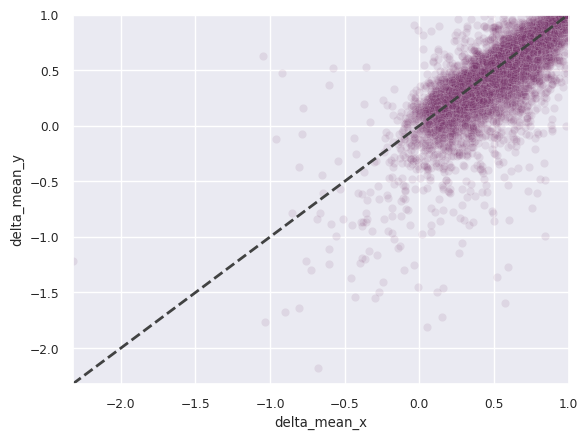

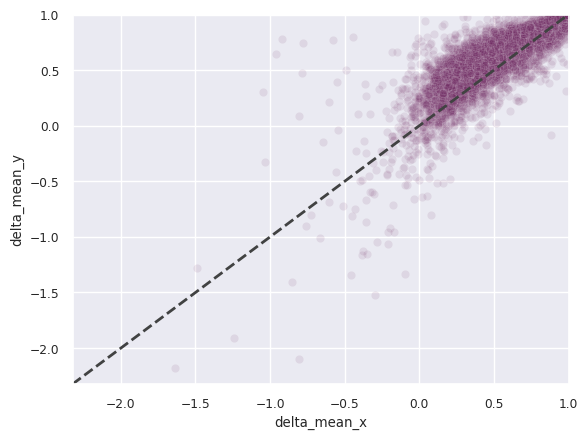

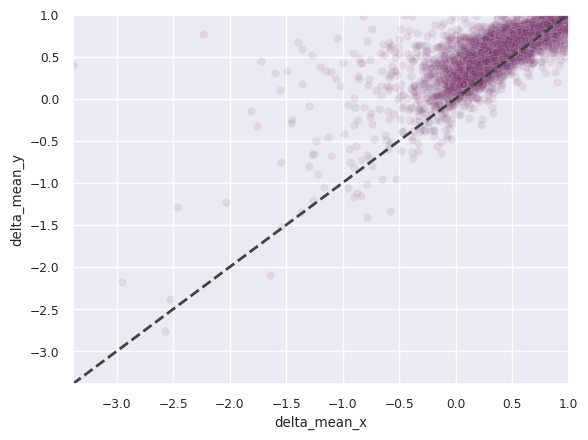

In [37]:
for df1, df2 in list(itertools.combinations([df for _, df  in summary_combined.groupby('cell_line')], 2)):
    diff_comp = df1.merge(df2, on='seq_id')
    sns.scatterplot(data=diff_comp, x='delta_mean_x', y='delta_mean_y', edgecolors=None, color='#702963', alpha=0.1)
    min_point = np.array(diff_comp['delta_mean_x'], diff_comp['delta_mean_y']).min()
    # add y=x line
    plt.plot([min_point,1],[min_point,1], lw=2, color='#414242', linestyle='dashed')
    # plt.xlabel(f'{c1} normalized TSS effect')
    # plt.ylabel(f'{c2} normalized TSS effect')
    plt.xlim(min_point,1)
    plt.ylim(min_point,1)
    plt.show()